In [23]:
import numpy as np
import pandas as pd

In [24]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
sns.set(style="whitegrid")

In [26]:
model = joblib.load("../src/model/churn_model.pkl")

In [27]:
df = pd.read_csv("../data/raw/Dataset.csv")

In [28]:
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})
df = df.drop(columns=["customerID"])

APPLY SAME FEATURE ENGINEERING

In [29]:
import sys 
sys.path.append("..")

In [30]:
from src.utils.preprocessing import apply_feature_engineering

In [31]:
df = apply_feature_engineering(df)

GLOBAL EXPLAINABILITY

Get Feature Names

In [32]:
preprocessor = model.named_steps["preprocessor"]
feature_names = preprocessor.get_feature_names_out()

Logistic Regression Coefficients

In [33]:
log_model = model.named_steps["model"]

In [34]:
coefficients = log_model.coef_[0]

In [35]:
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Abs_Impact": np.abs(coefficients)
}).sort_values(by="Abs_Impact", ascending=False)

In [36]:
coef_df.head(15)

,Feature,Coefficient,Abs_Impact
1,num__tenure,-0.934794,0.934794
40,cat__Contract_Two year,-0.926482,0.926482
38,cat__Contract_Month-to-month,0.754194,0.754194
18,cat__InternetService_Fiber optic,0.580788,0.580788
2,num__MonthlyCharges,-0.567592,0.567592
17,cat__InternetService_DSL,-0.550030,0.550030
3,num__TotalCharges,0.477435,0.477435
4,num__charge_per_tenure,0.359222,0.359222
14,cat__MultipleLines_No,-0.246479,0.246479
41,cat__PaperlessBilling_No,-0.239584,0.239584


Interpretation:
Positive → increases churn risk
Negative → reduces churn risk

VISUALIZE TOP CHURN DRIVERS

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10148\3815892605.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Text(0, 0.5, '')

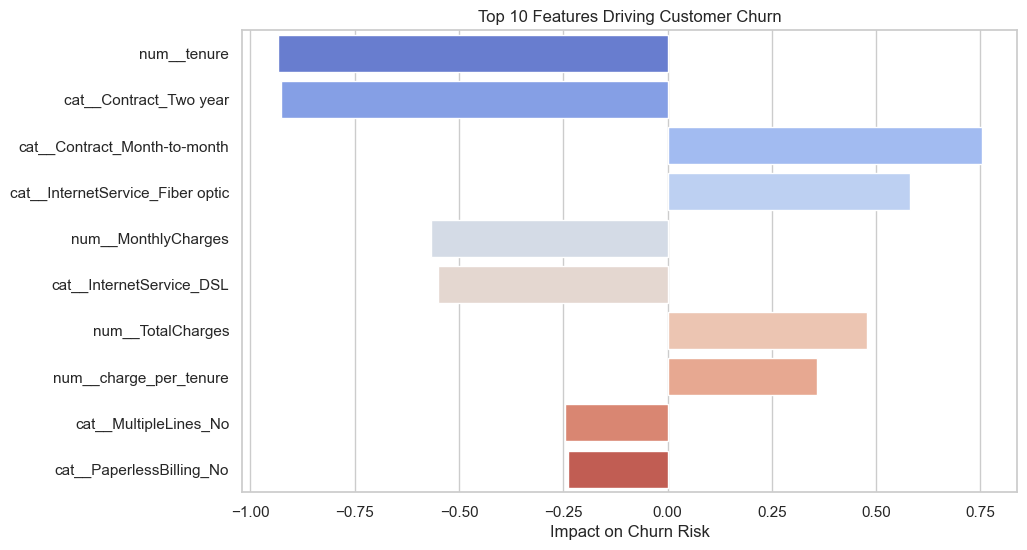

In [37]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=coef_df.head(10),
    x="Coefficient",
    y="Feature",
    palette="coolwarm"
)
plt.title("Top 10 Features Driving Customer Churn")
plt.xlabel("Impact on Churn Risk")
plt.ylabel("")



MAP FEATURES → BUSINESS DRIVERS

In [38]:
def map_to_business_driver(feature):
    if "tenure" in feature:
        return "Customer Lifecycle"
    elif "MonthlyCharges" in feature or "charge_per_tenure" in feature:
        return "Pricing Pressure"
    elif "Contract" in feature:
        return "Contract Commitment"
    elif "TechSupport" in feature or "OnlineSecurity" in feature:
        return "Support & Service Quality"
    elif "Streaming" in feature:
        return "Service Engagement"
    elif "PaymentMethod" in feature:
        return "Payment Behavior"
    elif "num_services" in feature:
        return "Service Adoption"
    else:
        return "Other"

coef_df["Business_Driver"] = coef_df["Feature"].apply(map_to_business_driver)


BUSINESS DRIVER IMPORTANCE

In [39]:
business_importance = (
    coef_df
    .groupby("Business_Driver")["Abs_Impact"]
    .sum()
    .sort_values(ascending=False)
)

business_importance


Business_Driver
Other                        3.842387
Contract Commitment          1.691574
Customer Lifecycle           1.564782
Support & Service Quality    1.039578
Service Engagement           1.033696
Payment Behavior             0.600503
Pricing Pressure             0.567592
Service Adoption             0.171468
Name: Abs_Impact, dtype: float64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Other'),
  Text(1, 0, 'Contract Commitment'),
  Text(2, 0, 'Customer Lifecycle'),
  Text(3, 0, 'Support & Service Quality'),
  Text(4, 0, 'Service Engagement'),
  Text(5, 0, 'Payment Behavior'),
  Text(6, 0, 'Pricing Pressure'),
  Text(7, 0, 'Service Adoption')])

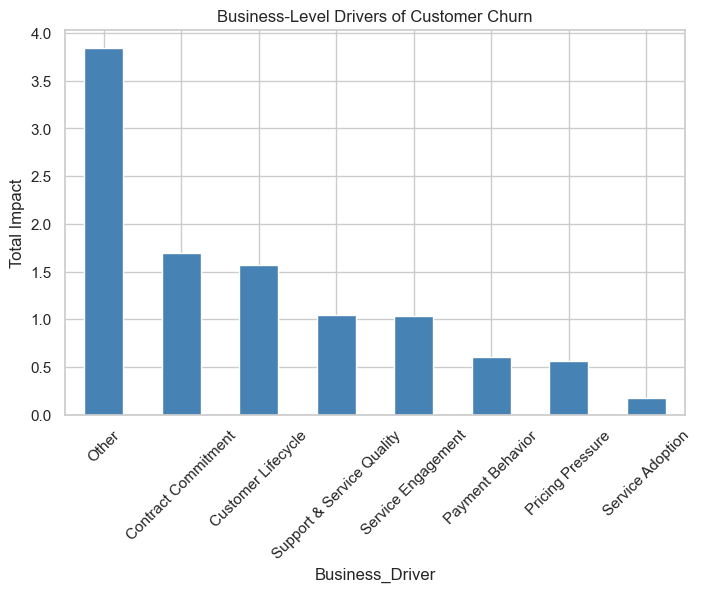

In [40]:
plt.figure(figsize=(8,5))
business_importance.plot(kind="bar", color="steelblue")
plt.title("Business-Level Drivers of Customer Churn")
plt.ylabel("Total Impact")
plt.xticks(rotation=45)

Executive takeaway:
Churn is mainly driven by customer lifecycle, pricing pressure, contract type, and lack of support.

INDIVIDUAL CUSTOMER EXPLANATION

In [41]:
def explain_customer(row):
    reasons = []

    if row["tenure"] < 12:
        reasons.append("New customer with low tenure")

    if row["MonthlyCharges"] > 80:
        reasons.append("High monthly charges")

    if row["Contract"] == "Month-to-month":
        reasons.append("No long-term contract")

    if row["TechSupport"] == "No":
        reasons.append("No technical support")

    if row["num_services"] <= 1:
        reasons.append("Low service engagement")

    return reasons


In [42]:
sample_customer = df.sample(1, random_state=42).iloc[0]
explain_customer(sample_customer)

['New customer with low tenure',
 'No long-term contract',
 'No technical support',
 'Low service engagement']

REVENUE AT RISK (DECISION INTELLIGENCE CORE)

In [44]:
df["Predicted_Churn_Prob"] = model.predict_proba(df.drop(columns=["Churn"]))[:, 1]

In [45]:
df["Revenue_At_Risk"] = df["Predicted_Churn_Prob"] * df["MonthlyCharges"] * 6

In [46]:
total_revenue_risk = df["Revenue_At_Risk"].sum()
total_revenue_risk


np.float64(1269821.3516279152)

WHERE IS REVENUE AT RISK?

In [47]:
df.groupby("Contract")["Revenue_At_Risk"].sum().sort_values(ascending=False)

Contract
Month-to-month    1.039945e+06
One year          1.691597e+05
Two year          6.071656e+04
Name: Revenue_At_Risk, dtype: float64

In [48]:
df.groupby("PaymentMethod")["Revenue_At_Risk"].sum().sort_values(ascending=False)

PaymentMethod
Electronic check             708650.879309
Bank transfer (automatic)    208179.257838
Credit card (automatic)      188962.553562
Mailed check                 164028.660919
Name: Revenue_At_Risk, dtype: float64

Business insight:
Month-to-month contracts and electronic check users contribute most to revenue risk.

We don’t just predict churn. We explain what drives it, quantify financial impact, and translate model insights into actionable business decisions